In [4]:
from scipy import io as sio
import tensorflow as tf
import numpy as np
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#step 1 loading and preprocessing EMNIST dataset 

 

  
import numpy as np
import sys

from keras.datasets import mnist
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle
import gzip
import matplotlib.pyplot as plt

# load train and test dataset
def load_mnist_online():
    """Do not use this one"""
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    # trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    # testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    # trainY = to_categorical(trainY)
    # testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def load_mnist_offline():
    """
    Taken from Nielsen, adapted for Python 3.
    Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    training_data, validation_data, test_data = cPickle.load(f)
    """
    f = gzip.open('../data/MNIST/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

def load_mnist():
    """ Loads the MNIST dataset via tensorflow_datasets.load(). At first execution downloads the database to a local
    directory (see documentation for tensorflow_datasets.load()), after that grabs database from this local directory.
    Returns training_data (60.000) and testing_data (10.000) each as a tuple of an input array 60.000x28x28 resp.
    10.000x28x28 with values between 0 and 255 and a result array of size 60.000 resp. 10.000 containing the associated
    label between 0 and 61 representing number, small letters and capital letters"""

    print('Loading MNIST database, this might take a while...')
    data = tfds.as_numpy(tfds.load(
        'mnist',
        batch_size=-1,
        as_supervised=True,
    ))

    training_data = list(data['train'])
    testing_data = list(data['test'])
    training_data[0] = training_data[0][:, :, :, 0]
    testing_data[0] = testing_data[0][:, :, :, 0]
    training_data = tuple(training_data)
    testing_data = tuple(testing_data)

    return (training_data, testing_data)

def load_emnist():
    """ Loads the EMNIST dataset via tensorflow_datasets.load(). At first execution downloads the database to a local
    directory (see documentation for tensorflow_datasets.load()), after that grabs database from this local directory.
    Returns training_data (697932) and testing_data (116323) each as a tuple of an input array 697932x28x28 resp.
    116323x28x28 with values between 0 and 255 and a result array of size 60.000 resp. 10.000 containing the associated
    labels between 0
    Warning: these tuples are very large and take up a lot of RAM"""
    print('Loading EMNIST database, this might take a while...')
    data = tfds.as_numpy(tfds.load(
        'emnist',
        batch_size=-1,
        as_supervised=True,
    ))

    training_data = list(data['train'])
    testing_data = list(data['test'])
    training_data[0] = tf.image.rot90(training_data[0], k=3)
    testing_data[0] = tf.image.rot90(testing_data[0], k=3)
    training_data[0] = tf.image.flip_left_right(training_data[0])
    testing_data[0] = tf.image.flip_left_right(testing_data[0])
    testing_data[0] = testing_data[0].numpy()
    training_data[0] = training_data[0].numpy()
    training_data[0] = training_data[0][:, :, :, 0]
    testing_data[0] = testing_data[0][:, :, :, 0]
    training_data = tuple(training_data)
    testing_data = tuple(testing_data)

    return (training_data, testing_data)


# The following is only relevant for neuralnetnp by Nielsen.
def vectorized_result(j):
    """ From Nielsen, used in load_data_wrapper()
    Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def load_data_wrapper():
    """ From Nielsen, adapted for Python 3.
    Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""

    tr_d, va_d, te_d = load_mnist_offline()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)









'''mat = sio.loadmat('emnist-letters.mat')
data = mat['dataset']



# this type of sample did not work as the other way of splitting so I pass for now 
x_train, x_test, y_train, y_test = train_test_split(data['train'][0,0]['images'][0,0],
                                                    data['train'][0,0]['images'][0,0],
                                                    test_size=0.2)
                                                    

#                                                              random_state=42

#define what the training and testing data are

x_train = data['train'][0,0]['images'][0,0] 
y_train = data['train'][0,0]['labels'][0,0]
x_test = data['test'][0,0]['images'][0,0]
y_test = data['test'][0,0]['labels'][0,0]

#I did not use cross-validation by now since it was not that inportant in this case
#_train = data['test'][0,0]['labels'][0,0]
#using cros validation 
#al_start = x_train.shape[0] - x_test.shape[0]
#_val =x_train[val_start:x_train.shape[0]]
#_val = y_train[val_start:y_train.shape[0]]
#_train = x_train[0:val_start]
#_train = y_train[0:val_start]'''


#reshape the arrays into image

#x_train = x_train.reshape( (x_train.shape[0], 28, 28), order='F')


    
    
    
  
    
#_train.shape, y_train.shape

#_test.shape, y_test.shape


#_train = x_train[..., tf.newaxis]
#_test = x_test[..., tf.newaxis]

#_train.shape

#_test.shape

#p.min(x_train), np.max(x_train)

#x_train = x_train / 255.
#x_test=x_test/255

#p.min(x_train), np.max(x_train)
#x_train = x_train.reshape( (x_train.shape[0], 28, 28), order='F')

#y_train = y_train.reshape( (y_train.shape[0], 28, 28), order='F')'''
#x_test = x_test.reshape( (x_test.shape[0], 28, 28), order='F')


#number of unique classes
'''classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


#reshaping the training and testing data


print('train shape', x_train.shape)
print('test shape', x_test.shape)'''




"classes = np.unique(y_train)\nnClasses = len(classes)\nprint('Total number of outputs : ', nClasses)\nprint('Output classes : ', classes)\n\n\n#reshaping the training and testing data\n\n\nprint('train shape', x_train.shape)\nprint('test shape', x_test.shape)"

In [5]:
load_emnist()

Loading EMNIST database, this might take a while...


c:\users\serem1\appdata\local\programs\python\python38\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.itl.nist.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Shuffling and writing examples to C:\Users\serem1\tensorflow_datasets\emnist\byclass\3.0.0.incomplete335LJ7\emnist-train.tfrecord


Shuffling and writing examples to C:\Users\serem1\tensorflow_datasets\emnist\byclass\3.0.0.incomplete335LJ7\emnist-test.tfrecord


Dataset emnist downloaded and prepared to C:\Users\serem1\tensorflow_datasets\emnist\byclass\3.0.0. Subsequent calls will reuse this data.


((array([[[ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  2,  0,  0],
          ...,
          [ 0,  0, 18, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0]],
  
         [[ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          ...,
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0]],
  
         [[ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          ...,
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0]],
  
         ...,
  
         [[ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          ...,
          [ 0,  0,  0, ...,  0,  0,  0],
         

In [51]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

training_data, test_data = load_emnist()
(x_train, y_train) = training_data
(x_test, y_test) = test_data

x_train, x_test, y_train, y_test = train_test_split(data['train'][0,0]['images'][0,0],
                                                    data['train'][0,0]['images'][0,0],
                                                    test_size=0.2, random_state=13)



Loading EMNIST database, this might take a while...


KeyboardInterrupt: 

In [8]:
x_train = x_train.reshape( (x_train.shape[0], 28, 28), order='F')
x_test = x_test.reshape( (x_test.shape[0], 28, 28), order='F')

#number of unique classes
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


#reshaping the training and testing data


print('train shape', x_train.shape)
print('test shape', x_test.shape)


Total number of outputs :  62
Output classes :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
train shape (697932, 28, 28)
test shape (116323, 28, 28)


Text(0.5, 1.0, 'Ground Truth : 24')

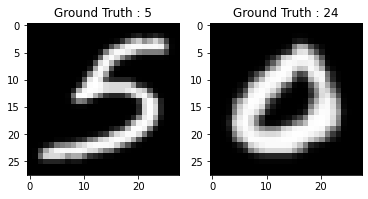

In [15]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(x_train[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_train[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(x_test[0,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_test[0]))

In [16]:
#reshaping the training and testing data
x_train = x_train.reshape(-1, 28,28, 1)
x_test = x_test.reshape(-1, 28,28, 1)
x_train.shape, x_test.shape



((697932, 28, 28, 1), (116323, 28, 28, 1))

In [17]:
#converting the data from int8 to float32

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.
x_test = x_test / 255.



In [18]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Display the change for category label using one-hot encoding
print('Original label:', y_train[3])
print('After conversion to one-hot:', y_train_one_hot[0])


Original label: 8
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
batch_size = 64
epochs = 3
num_classes = 62

In [20]:
#built the model

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


model.summary()

'''Let's visualize the layers that you created in the above step by using the summary function. 
This will show some parameters (weights and biases) in each layer and also the total parameters in your model'''

#train the model/fiting 

model_train = model.fit(x_train, y_train_one_hot, batch_size=batch_size,epochs=epochs, verbose =1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)        

In [21]:
test_eval = model.evaluate(x_test, y_test_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])



Test loss: 0.3499849965832159
Test accuracy: 0.8689253330230713


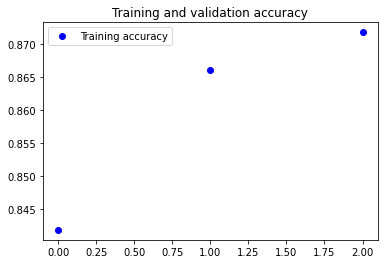

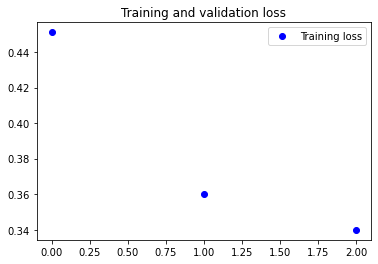

In [22]:
#now we analyse our model and see what can be done to make it better

accuracy = model_train.history['accuracy']
#val_acc = model_train.history['val_accuracy']
loss = model_train.history['loss']
#val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
#plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [34]:
model.save("emnist_let_read.model")

In [35]:
new_model = tf.keras.models.load_model("emnist_let_read.model")

In [36]:
prediktions = new_model.predict(x_test)
print(prediktions)


[[2.9259175e-01 4.4318102e-07 1.2138952e-06 ... 2.6216883e-08
  8.8750429e-09 6.2192484e-08]
 [4.8723667e-08 8.4341116e-07 9.5469999e-01 ... 5.4796146e-07
  5.6627403e-07 3.0134895e-03]
 [5.0377869e-10 7.3464843e-09 9.7720010e-07 ... 1.7564714e-11
  2.8490696e-09 2.2838774e-05]
 ...
 [6.7897162e-08 8.4296316e-06 9.4426165e-09 ... 7.4457501e-05
  8.6386550e-05 1.5396660e-06]
 [3.5506556e-08 7.2579240e-07 1.8124704e-08 ... 1.6636343e-09
  3.4273139e-06 1.2539826e-08]
 [5.8285428e-07 7.5491135e-07 1.4795678e-06 ... 1.3981091e-10
  8.3450018e-08 5.7121543e-08]]


In [42]:
print(np.argmax(prediktions[24]))



28


In [23]:
predicted_classes = model.predict(x_test)
#need to use argmax function to find the one prediction with the highest probability
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [24]:
predicted_classes.shape, y_test.shape


((116323,), (116323,))

Found 1351 correct labels


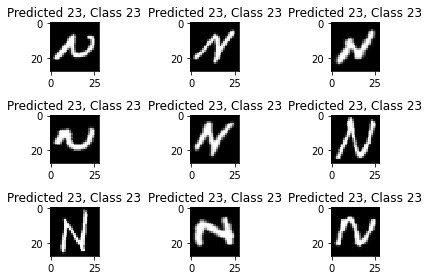

In [50]:
correct = np.where(predicted_classes[32513]==y_test)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()
    
    



Found 110354 incorrect labels


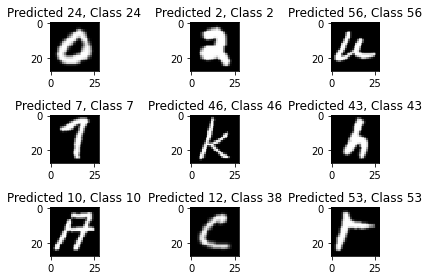

In [29]:
#now for the incorrect ones
incorrect = np.where(predicted_classes[86]!=y_test)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

In [30]:
'''Classification report will help us in identifying the misclassified classes in more detail.
You will be able to observe for which class the model performed bad out of the given 26 classes'''


from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

c:\users\serem1\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Class 0       0.44      0.85      0.58      5778
     Class 1       0.73      0.79      0.76      6330
     Class 2       0.96      0.97      0.97      5869
     Class 3       0.99      0.99      0.99      5969
     Class 4       0.98      0.97      0.97      5619
     Class 5       0.94      0.95      0.95      5190
     Class 6       0.97      0.99      0.98      5705
     Class 7       0.99      0.99      0.99      6139
     Class 8       0.98      0.99      0.98      5633
     Class 9       0.94      0.97      0.96      5686
    Class 10       0.96      0.97      0.96      1062
    Class 11       0.95      0.92      0.94       648
    Class 12       0.78      0.93      0.85      1739
    Class 13       0.94      0.88      0.91       779
    Class 14       0.97      0.94      0.96       851
    Class 15       0.81      0.89      0.85      1440
    Class 16       0.97      0.86      0.91       447
    Class 17       0.95    